<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/8-Generative/dcganowndata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network owndata

DCGAN   iki parçalı bir sistemdir. Generator ve Discriminator eğitilir. Böylece amaca uygun bir görüntü oluşturmaya çalışan Generator ve onu yakalmaaya çalışan Discriminator oluşur. Ne zaman discriminator kandırlırsa o zaman sonuç verilir bu yüzden adverserial sayılır.

### Setup


Tensorflow ve diğer gereksinimler

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.18.0'

In [3]:
# Bu sonrasında şov amaçlı ara parçaları görmek için epoch sonuçlarından gif yapacağız.
!pip install imageio -q
!pip install git+https://github.com/tensorflow/docs -q

  Preparing metadata (setup.py) ... done


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### Load and prepare the dataset




Eğer kendi datasetinde çalışmak istersen

In [5]:
!wget -q  https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/8-Generative/db64miniset.zip

In [6]:
!unzip -qq db64miniset.zip

In [45]:
##set your data size input
img_size=64

In [8]:
import numpy as np
import tensorflow as tf
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Dataset yükleme fonksiyonu
def load_custom_images(image_dir, img_size=(img_size, img_size)):
    image_paths = glob.glob(image_dir + "/*.png")  # Adjust extension if needed
    images = [img_to_array(load_img(img, color_mode="grayscale", target_size=img_size)) for img in image_paths]
    images = np.array(images).astype("float32") / 127.5 - 1  # Normalize to [-1, 1]
    return images

# Replace dataset loading
image_dir = "db64miniset"
train_images = load_custom_images(image_dir)

# Ensure correct shape
train_images = train_images.reshape(train_images.shape[0], img_size, img_size, 1)

# Create TensorFlow dataset
BUFFER_SIZE = len(train_images) # kaç adet görsel var
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


## Create the models

Generator ve discriminator [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model) Kullanır.

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [46]:
def make_generator_model():
    global img_size
    assert img_size % 16 == 0, "img_size must be a multiple of 16"

    base_size = img_size // 16  # For example, if img_size=64, base_size=4

    model = tf.keras.Sequential()

    # Explicit input layer
    model.add(tf.keras.Input(shape=(100,)))

    # First dense layer
    model.add(layers.Dense(base_size * base_size * 256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((base_size, base_size, 256)))
    assert model.output_shape == (None, base_size, base_size, 256)

    # Upsample 1 (Base size -> Base*2)
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample 2 (Base*2 -> Base*4)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample 3 (Base*4 -> img_size)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

     # Upsample 4 (Base*4 -> img_size)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))


    # Ensure final size matches img_size exactly
    final_output_shape = model.output_shape
    crop_h = final_output_shape[1] - img_size
    crop_w = final_output_shape[2] - img_size

    if crop_h > 0 or crop_w > 0:
        model.add(layers.Cropping2D(((0, crop_h), (0, crop_w))))

    return model


Use the (as yet untrained) generator to create an image.

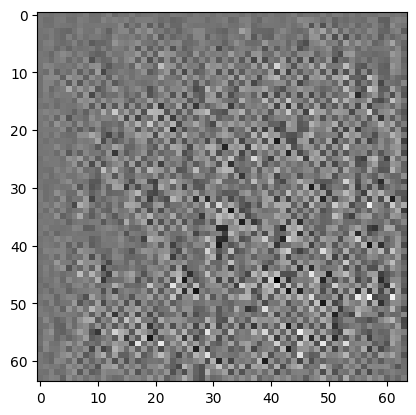

In [47]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### The Discriminator

Discriminator CNN mantığı ile çalışsan bir classification yapısıdır.

In [48]:


def make_discriminator_model():
    global img_size
    assert img_size % 16 == 0, "img_size must be a multiple of 16"

    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(img_size, img_size, 1)))  # Dynamic input size

    # Start with 64 filters and double them each time
    filters = 64
    num_layers = int(tf.math.log(float(img_size)) / tf.math.log(2.0)) - 3  # Adjust layers based on size

    for _ in range(num_layers):
        model.add(layers.Conv2D(filters, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))
        filters *= 2  # Double filters at each layer

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [49]:
generated_image = generator(tf.random.normal([1, 100]), training=False)
print(generated_image.shape)  # Should be (1, img_size, img_size, 1)

(1, 64, 64, 1)


In [50]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0003136]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [51]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [52]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [53]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [54]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [67]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [80]:
EPOCHS = 300
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [57]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [58]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [59]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

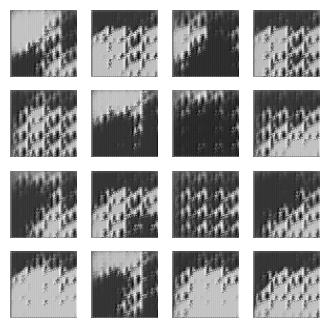

Time for epoch 197 is 1.8842649459838867 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [82]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [62]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

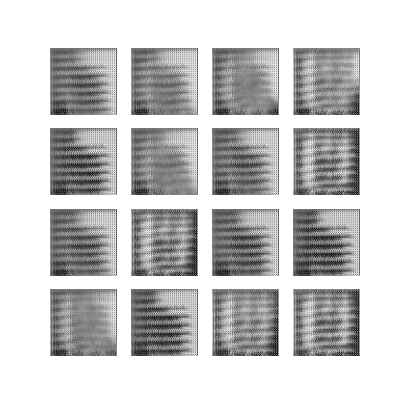

In [63]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [64]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-64-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-64-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



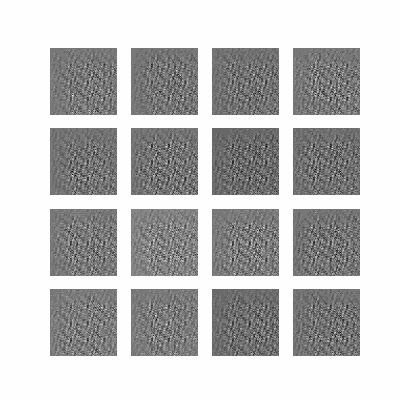

In [65]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

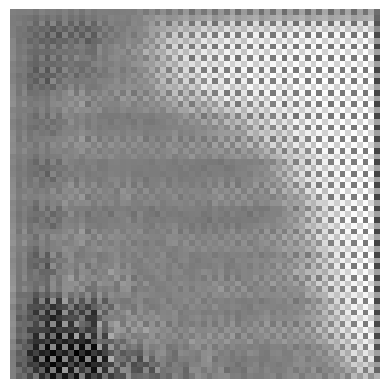

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise (latent vector)
latent_dim = 100  # Same as used in training
random_noise = tf.random.normal([1, latent_dim])

# Generate an image
generated_image = generator(random_noise, training=False)

# Rescale pixel values from [-1, 1] to [0, 1]
generated_image = (generated_image + 1) / 2.0

# Display the image
plt.imshow(generated_image[0, :, :, 0], cmap="gray")  # Use cmap="gray" for grayscale
plt.axis("off")
plt.show()
